In [0]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, transforms

from PIL import Image
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import clear_output, display

np.set_printoptions(precision=2)
plt.rcParams['figure.figsize'] = (14.0, 10.0)

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [0]:
# https://pytorch.org/docs/stable/torchvision/models.html
#normalize with provided mean and std for pretrained models
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def img2tensor(img):
    normalize = transforms.Normalize(mean=mean, std=std)

    tfms = transforms.Compose([
        transforms.Resize(512),
        transforms.ToTensor(),
        normalize
    ])
    
    img = tfms(img)
    img = img.unsqueeze(0)
    
    return img


def tensor2img(tensor):
    img = tensor.clone().detach().cpu().numpy().squeeze().transpose(1, 2, 0)
    img = img * np.array(std) + np.array(mean)
    # img = img.clip(0, 1)
      
    return img

content_img = Image.open('dog-snake.jpg').convert('RGB') 
style_img = Image.open('ana.jpg').convert('RGB') 

style_tensor = img2tensor(style_img)
content_tensor = img2tensor(content_img)

In [0]:
# display(style_img)
# display(content_img)
# display(style_img.size, content_img.size)

# plt.figure()
# plt.imshow(tensor2img(style_tensor))
# plt.figure()
# plt.imshow(tensor2img(content_tensor))

In [0]:
model = models.vgg19(pretrained = True).features

for p in model.parameters():
    p.requires_grad_(False)

In [0]:
model = model.to(device)
style_tensor = style_tensor.to(device)
content_tensor = content_tensor.to(device)

In [43]:
style_layers = [0, 5, 10, 19, 28]
style_weights = [1, 2, 1, 0.35, 0.25, 5]
content_layers = [28, 30, 32]
content_weights = [0, 5, 5]

layers = sorted(style_layers + content_layers)
display(layers)


def extract_features(x, model):
    features = {}

    for i, (name, layer) in enumerate(model._modules.items()):
        x = layer(x)
        if i in layers:
            features[i] = x
    
    return features


def calc_gram_matrix(tensor):
    _, channels, height, width = tensor.size()
    tensor = tensor.view(channels, height * width)
    gram_m = torch.mm(tensor, tensor.t())
    gram_m = gram_m.div(channels * width * height)
    
    return gram_m
    
style_ftrs = extract_features(style_tensor, model)
style_ftrs_gram_m = { layer: calc_gram_matrix(style_ftrs[layer]) for layer in style_ftrs }
content_ftrs = extract_features(content_tensor, model)


display(style_ftrs_gram_m[0].dtype)
display(content_ftrs.keys())

[0, 5, 10, 19, 28, 28, 30, 32]

torch.float32

dict_keys([0, 5, 10, 19, 28, 30, 32])

In [0]:
target = content_tensor.clone().requires_grad_(True)

In [0]:
images = []

In [66]:

def arr2tensor(arr):
  tensor = arr.copy().transpose(2, 0, 1)
  tensor = (tensor - mean) / std

  return torch.tensor(tensor)

target = arr2tensor(images[-1])

ValueError: ignored

In [52]:
epochs = 51
style_loss_weights = [1e9]
lrs = [0.3, 1e-1, 1e-2, 1e-2, 1e-3]

optimizer = optim.Adam([target], lr=1e-2)



def get_idx(list, progress):
  return len(list) * progress

prev_lr_idx = -1
for epoch in range(epochs):
    progress = epoch / epochs

    style_loss_weight = style_loss_weights[0]
  
    lr_idx = int(progress * len(lrs))
    if lr_idx != prev_lr_idx:
      lr = lrs[lr_idx]
      prev_lr_idx = lr_idx
      for param_group in optimizer.param_groups:
          param_group['lr'] = lr


    target_ftrs = extract_features(target, model)
    
    content_loss = 0
    for l, w in zip(content_layers, content_weights):
        # m = torch.sin(torch.arange(content_ftrs[l].numel(), dtype=torch.float64).view(content_ftrs[l].shape) + (epoch/epochs) * np.pi).to(device)
        # content_ftrs[l] = content_ftrs[l] * m
        content_loss += F.mse_loss(target_ftrs[l], content_ftrs[l]) * w
        
    style_loss = 0
    for l, w in zip(style_layers, style_weights):
        target_ftrs_gram_m = { layer: calc_gram_matrix(target_ftrs[layer]) for layer in style_ftrs }
        style_loss += F.mse_loss(target_ftrs_gram_m[l], style_ftrs_gram_m[l]) * w
        
        
    total_loss = content_loss + style_loss * style_loss_weight

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
 
    if epoch % 10 == 0:
        print(f'epoch {epoch}', style_loss.item() * style_loss_weight, content_loss.item())
 
    if epoch % 10 == 0:
      img = tensor2img(target)
      images.append(img)


RuntimeError: ignored

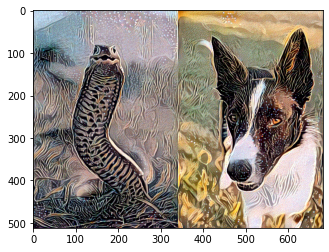

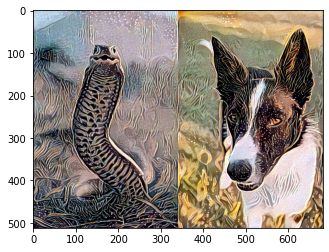

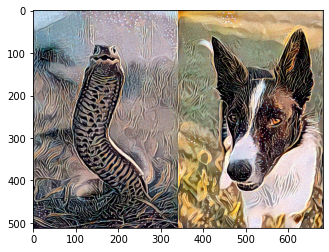

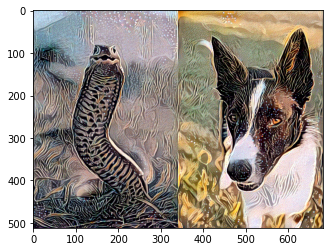

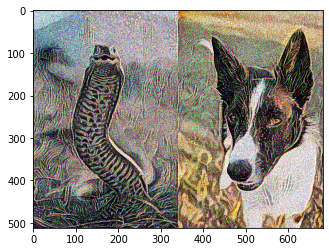

In [50]:
start = len(images) - 5
end = len(images)

for i in range(start, end):
  pil_img = Image.fromarray(np.clip(np.round(images[i] * 255), 0, 255).astype('uint8'))
  pil_img.save(f'{i}.jpg')

for i in range(start, end):
  img = images[i]
  plt.figure()
  plt.imshow(img)

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# !mkdir /content/drive/'My Drive'/test
!cp *jpg /content/drive/'My Drive'/test

In [73]:
!convert -delay 100 -loop 0 *.jpg animatedGIF.gif

/bin/bash: convert: command not found
